In [185]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from datetime import datetime
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn import svm
from sklearn.metrics import mean_squared_error
from scipy.stats import shapiro

% config InlineBackend.figure_format = 'png'
% matplotlib inline

In [186]:
def read_data(filename):
    dataset = pd.read_csv(filename)
    return dataset

In [187]:
def evaluate_rmse(dataset):
    return np.sqrt(mean_squared_error(dataset['Revenue'], dataset['Predicted']))    

In [188]:
def parse_date(train):
    
    # Assume a date which is later than latest opening date of all the restaurants
    latest_date = datetime.strptime("01/01/2015", '%m/%d/%Y')
    
    open_num_days = []
    open_month = []
    open_year = []

    for date in train['Open Date']:
        cur_date = datetime.strptime(date, '%m/%d/%Y')
        open_num_days.append((latest_date - cur_date).days)
        open_month.append(cur_date.month)
        open_year.append(cur_date.year)

    train['Days'] = open_num_days
    train['Month'] = open_month
    train['Year'] = open_year

In [189]:
def adjust_type(data):
    
    # Augment data with id for original order of records
    data.loc[:, "tempIdx"] = data.index
    
    # Get records with restaurant type = "Mobile"
    query_matrix = data.loc[data.Type == "MB", :]
    
    # Get records with restaurant type != "Mobile"
    search_matrix = data.loc[data.Type != "MB", :]

    # Use only continuous features for classification
    features = data.columns.values[4:]

    # Predict known type using KNN
    clf = KNeighborsClassifier(n_neighbors=5)
    clf.fit(search_matrix.loc[:, features], search_matrix.loc[:, 'Type'])
    query_matrix.loc[:, 'Type'] = clf.predict(query_matrix.loc[:, features])
    
    # Construct data to original form and order
    data = pd.concat((search_matrix.loc[:, "Open Date" : "tempIdx"],
                      query_matrix.loc[:, "Open Date" : "tempIdx"]), ignore_index = True)
    data = data.sort_values(["tempIdx"])
    data.drop("tempIdx", 1)
    
    return data

In [190]:
# Read the dataset
train = read_data("../data/train.csv")
test = read_data("../data/test.csv")

In [191]:
# Calculate number of samples in training and test datasets
num_train = train.shape[0]
num_test = test.shape[0]

In [192]:
# For feature engineering, combine train and test data
data = pd.concat((train.loc[:, 'Open Date':'P37'], test.loc[:, 'Open Date':'P37']), ignore_index=True)

In [193]:
# Parse date of opening of restaurant to get the number of days it has stayed open, month in which it opened
# and year in which it opened. The additional month and year features can potentially help proxy seasonality
# differences since restaurant revenues are highly cylical.
parse_date(data)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f12b29c8588>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f12b25e84e0>]], dtype=object)

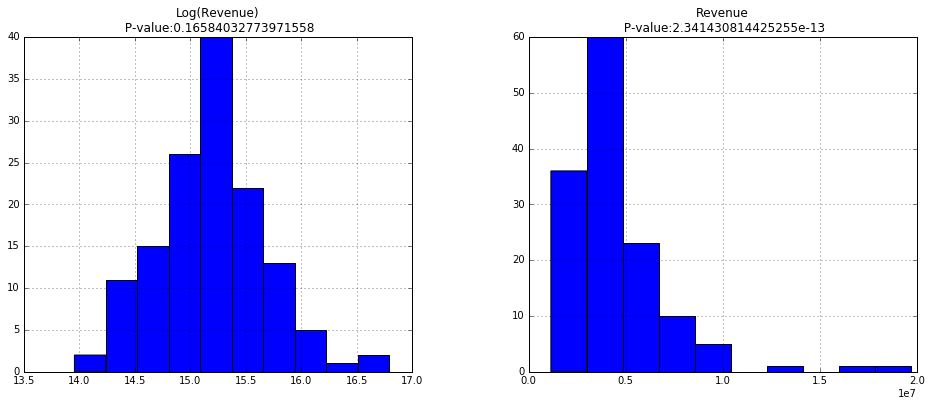

In [194]:
# Check distribution of revenue and log(revenue)
plt.rcParams['figure.figsize'] = (16.0, 6.0)
pvalue_before = shapiro(train["Revenue"])[1]
pvalue_after = shapiro(np.log(train["Revenue"]))[1]
graph_data = pd.DataFrame(
        {
            ("Revenue\n P-value:" + str(pvalue_before)) : train["Revenue"],
            ("Log(Revenue)\n P-value:" + str(pvalue_after)) : np.log(train["Revenue"])
        }
    )
graph_data.hist()

In [195]:
# log transform revenue as it is approximately normal. If this distribution for revenue holds in the test set,
# log transforming the variable before training models will improve performance vastly.
# However, we cannot be completely certain that this distribution will hold in the test set.
train["Revenue"] = np.log(train["Revenue"])

In [ ]:
data = adjust_type(data)